In [41]:
import tqdm
import pickle
import random
import numpy as np

from time import sleep
from collections import defaultdict
from grid import Grid, RandomGridGenerator

from IPython.display import clear_output
from utils import two_int_to_hash, numpy_arr_to_str, approximate_5x5_to_3x3

In [51]:
# GLOBAL CONFIGS
GRID_NUMBER_OF_ROWS = 100
GRID_NUMBER_OF_COLS = 100

PREDATOR_VISION_DIST = 3
PREY_VISION_DIST = 2

PREDATOR_VALUE = 2
PREY_VALUE = 1

PREDATOR_APPROXIMATE_SHARE = 0.3
PREY_APPROXIMATE_SHARE = 0.7

PREDATOR_DEFAULT_HEALTH = 200
PREY_DEFAULT_HEALTH = 10000

alpha = 0.1
gamma = 0.6
epsilon = 0.1

action_space = [
    "up",
    "down",
    "left",
    "right",
    "stay",
]

[]

action_idxs = [0,1,2,3,4]


with open("DL_pretrained_model/predator_q_table.pickle", "rb") as f:
    pre_trained_data_predator = pickle.load(f)

    
with open("DL_pretrained_model/prey_q_table.pickle", "rb") as f:
    pre_trained_data_prey = pickle.load(f)


In [52]:
pre_trained_data_prey

{'220|111|022': [1.0,
  2.8978849168200103e-28,
  7.4876542573021755e-16,
  1.8198676256569852e-20,
  7.030160380484899e-17],
 '220|011|022': [4.321962574068902e-14,
  4.025194416602991e-14,
  4.3674896005541086e-05,
  2.67688782251696e-09,
  0.9999563694000244],
 '212|211|022': [1.0,
  2.189605579640784e-16,
  1.0303256511856596e-11,
  4.143586445690123e-16,
  1.8778552357527368e-16],
 '012|211|010': [0.999996542930603,
  4.888868754271414e-10,
  3.3879499028444116e-07,
  3.145738673993037e-06,
  8.854611266428947e-09],
 '212|111|022': [1.0,
  4.009510009162637e-13,
  4.3129450011392123e-10,
  1.5916569006801246e-14,
  3.479545210988144e-13],
 '000|211|202': [9.450071699838438e-26,
  0.9998579025268555,
  2.461157464495045e-06,
  0.00013955359463579953,
  1.2497097845768582e-14],
 '010|010|000': [6.873609064037803e-29,
  3.209584420460487e-08,
  0.35571059584617615,
  0.3367597460746765,
  0.3075295686721802],
 '010|211|112': [1.0,
  2.251766888184889e-13,
  2.0905275288640723e-09,
  

In [53]:
class AgentNet:
    def __init__(self, _type):
        self.q_table = dict()
        self._type = _type

    def choose_next_cell(self, state):
        if state.shape[0] == 5:
            state = approximate_5x5_to_3x3(state)

        hashed_state = numpy_arr_to_str(state)

        if hashed_state not in self.q_table:
             self.q_table[hashed_state] = self._get_default_knowledge(hashed_state)

        allowed_actions = self._get_allowed_actions(state)

        if random.uniform(0, 1) < epsilon:
            return random.choice(allowed_actions)
        else:
            return np.argmax(self.q_table[hashed_state][allowed_actions,])

    def _get_allowed_actions(self, state):
        actions = [4]

        if state[0][1] == 0:
            actions.append(0)

        if state[2][1] == 0:
            actions.append(1)

        if state[1][0] == 0:
            actions.append(2)

        if state[1][2] == 0:
            actions.append(3)

        return actions

    def _get_default_knowledge(self, hashed_state):
        if self._type == "predator":
            val = pre_trained_data_predator[hashed_state]
        elif self._type == "prey":
            val = pre_trained_data_prey[hashed_state]

        else:
            raise Exception(f"Invalid type {_type}")
        return np.array(
            [
            val[1],
            val[3],
            val[4],
            val[2],
            val[0],])



In [54]:
predator_net = AgentNet("predator")
prey_net = AgentNet("prey")

In [55]:
class Animal:
    __slots__ = "last_move", "remaining_life", "_type"
    def __init__(self, remaining_life, _type):
        self.last_move = None
        self.remaining_life = remaining_life
        self._type = _type

    def process_epoch(self):
        self.remaining_life -= 1

    def move(self, vision_matrix):
        if self._type == PREDATOR_VALUE:
            return predator_net.choose_next_cell(vision_matrix)
        elif self._type == PREY_VALUE:
            return prey_net.choose_next_cell(vision_matrix)


In [56]:
def get_dest_from_action(action, row, col):
    action = action_space[action]
    if action == "down":
        return (row+1) % GRID_NUMBER_OF_ROWS, col

    elif action == "up":
        return (row-1) % GRID_NUMBER_OF_ROWS, col

    elif action == "left":
        return row, (col-1)%GRID_NUMBER_OF_COLS

    elif action == "right":
        return row, (col+1)%GRID_NUMBER_OF_COLS

    elif action == "stay":
        return row, col

    else:
        raise Exception(f"Action can't be {action}")
    
def grid_of_nums_to_objects(grid: Grid) -> np.array:
    new_grid = np.empty(grid.grid.shape, dtype=object)
    for rowidx, row in enumerate(grid.grid):
        for colidx, val in enumerate(row):
            if val == PREDATOR_VALUE:     
                new_grid[rowidx][colidx] = Animal(PREDATOR_DEFAULT_HEALTH, PREDATOR_VALUE)
            elif val == PREY_VALUE:
                new_grid[rowidx][colidx] = Animal(PREY_DEFAULT_HEALTH, PREY_VALUE)

    return new_grid


In [57]:
rgg = RandomGridGenerator(GRID_NUMBER_OF_ROWS, GRID_NUMBER_OF_COLS)

generated_grid = rgg.getGrid(round(PREDATOR_APPROXIMATE_SHARE * 100) * [PREDATOR_VALUE] + round(PREY_APPROXIMATE_SHARE * 100) * [PREY_VALUE])

In [58]:


grid = Grid(generated_grid)
object_grid = grid_of_nums_to_objects(grid)
prey_c = []
pred_c = []
states = []

for time in tqdm.tqdm(range(10000)):

    next_grid = np.zeros((grid.rown, grid.coln))
    next_object_grid = np.empty(object_grid.shape, dtype=object)

    states.append(grid.grid)
    for row, line in enumerate(grid.grid):
        for col, item in enumerate(line):
            if item == PREY_VALUE:
                prey: Animal = object_grid[row][col]
                prey.process_epoch()
                if prey.remaining_life == 0:
                    grid.grid[row][col] = 0
                    object_grid[row][col] = None
                    continue

                if time % 4 == 0:
                    vision_space = grid.getNeighbors(row, col, PREY_VISION_DIST)
                    action = prey.move(vision_space)

                    dest = get_dest_from_action(action, row, col)
                    next_grid[dest[0], dest[1]] = item
                    next_object_grid[dest[0], dest[1]] = prey

                else:
                    next_grid[row, col] = item
                    next_object_grid[row, col] = prey

            if item == PREDATOR_VALUE:
                predator: Animal = object_grid[row][col]
                predator.process_epoch()
                if predator.remaining_life == 0:
                    grid.grid[row][col] = 0
                    object_grid[row][col] = None
                    continue

                if time % 3 == 0:
                    reward = 0
                    vision_space = grid.getNeighbors(row, col, PREDATOR_VISION_DIST)
                    action = predator.move(vision_space)

                    dest = get_dest_from_action(action, row, col)
                    if next_grid[dest[0], dest[1]] == PREY_VALUE:
                        reward = 1
                        predator.remaining_life += 100


                    app_next_vs = approximate_5x5_to_3x3(grid.getNeighborsFromNext(next_grid, dest[0], dest[1], PREDATOR_VISION_DIST))
                    app_vs = approximate_5x5_to_3x3(vision_space)

                    if predator_net.q_table.get(numpy_arr_to_str(app_next_vs)) is None:
                        predator_net.q_table[numpy_arr_to_str(app_next_vs)] = predator_net._get_default_knowledge(numpy_arr_to_str(app_next_vs))

                    max_value = np.max(predator_net.q_table[numpy_arr_to_str(app_next_vs)])
                    new_q_value = (1 - alpha) * predator_net.q_table[numpy_arr_to_str(app_vs)][action] + alpha * (reward + gamma * max_value)

                    # if reward == 1:
                    #     clear_output(wait=True)
                    #     print()
                    #     print(predator_net.q_table[numpy_arr_to_str(app_vs)][action])
                    #     print(new_q_value)
                    #     print()
                    #     sleep(0.5)

                    predator_net.q_table[numpy_arr_to_str(app_vs)][action] = new_q_value



                    next_grid[dest[0], dest[1]] = item
                    next_object_grid[dest[0], dest[1]] = predator

                else:
                    next_grid[row, col] = item
                    next_object_grid[row, col] = predator

    grid = Grid(next_grid)
    object_grid = next_object_grid


    prey_count = np.count_nonzero(grid.grid == PREY_VALUE)
    pred_count = np.count_nonzero(grid.grid == PREDATOR_VALUE)
    prey_c.append(prey_count)
    pred_c.append(pred_count)

    if pred_count == 0:
        print("no more animals on the grid")
        break;
        # for row, line in enumerate(grid.grid):
        #     for col, item in enumerate(line):
        #         if item == 0 and random.uniform(0,1) < 0.1:
        #             grid.grid[row][col] = PREY_VALUE

    # if time % 100 == 0:
    # clear_output(wait=True)
    # print("Episode: {}".format(time + 1))
    # print(grid.grid)
    # print(object_grid)


  1%|▎                                      | 84/10000 [00:00<00:14, 694.19it/s]

no more animals on the grid


In [59]:
len(pred_c)
len(prey_c)


85

In [23]:
from matplotlib import pyplot as plt


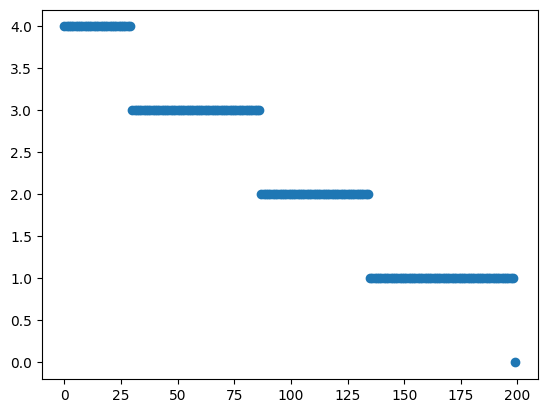

In [25]:
plt.scatter(list(range(len(pred_c))), pred_c)
# plt.scatter(list(range(len(pred_c))), prey_c)
plt.show()